# Credit Risk Analysis: Loan Default Prediction
## NB03 — Feature Engineering

### Why Feature Engineering Matters in Credit Risk

Raw data tells you *what* a borrower looks like on paper: their income, their loan amount, how many credit accounts they have. Engineered features tell you something deeper — *how financially stressed* they are, *how they behave* under credit pressure, and *how their risk factors interact* with each other.

A lender reviewing a loan application doesn't just look at income in isolation. They ask: "Is this person's income stretched thin covering their debts? Are they frantically applying for new credit? Have they shown a pattern of late payments, or was it a one-time event five years ago?" Good feature engineering encodes these intuitions as quantitative signals the model can learn from.

This is where finance domain knowledge matters most, and it's often the difference between a model that memorizes historical patterns and one that genuinely captures financial risk.

**What this notebook produces:**
- 6 groups of engineered features covering debt stress, utilization behavior, delinquency severity, binary risk flags, credit history depth, and interaction effects
- A correlation analysis comparing engineered features to raw features
- A final feature set saved to disk for NB04 modeling


In [ ]:
from pathlib import Path
import os

# Locate project root by walking up until we find the .git directory.
# This makes the notebook portable — no hardcoded filesystem paths.
root = Path.cwd()
while not (root / '.git').exists() and root != root.parent:
    root = root.parent
os.chdir(root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy.stats import pointbiserialr
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11
sns.set_theme(style='whitegrid', palette='muted')

# ── Load clean dataset from NB02 ──────────────────────────────────────────────
df = pd.read_parquet('data/clean/lending_club_clean.parquet')
print(f"Loaded clean dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Columns: {list(df.columns)}")

---
## Group 1: Debt Stress Indicators

**What these capture:** A borrower with a $5,000 monthly income and a $3,000 monthly loan payment is far more stressed than one with $15,000 income and the same payment — even though the loan amount is identical. Debt stress features normalize payment obligations against income, revealing whether a borrower is financially stretched.

**The key question these features answer:** "Is this borrower living within their means, or are their debt obligations crowding out their ability to absorb a financial shock?"

Three signals we'll engineer:
1. **`monthly_payment_burden`** — what fraction of monthly take-home does the loan installment consume? Above ~15–20% starts to signal stress.
2. **`loan_to_income_ratio`** — total loan size relative to annual income. High ratios mean the borrower needs years of income to repay — higher risk.
3. **`dti_util_stress`** — DTI is already in our dataset, but combined with revolving utilization it reveals a borrower who is maxed out on *all* forms of credit simultaneously, not just installment debt.


In [2]:
# ── Group 1: Debt Stress Indicators ─────────────────────────────────────────

# Monthly payment burden: loan installment as a fraction of monthly income.
# installment is the fixed monthly payment; annual_inc/12 is monthly income.
# A ratio > 0.2 (20%) indicates the loan alone takes >20% of monthly income.
df['monthly_payment_burden'] = df['installment'] / (df['annual_inc'] / 12)

# Loan-to-income ratio: total loan amount relative to annual income.
# Intuition: a $30k loan on $30k income = ratio of 1.0; highly stressful.
# A $30k loan on $100k income = ratio of 0.3; much more manageable.
df['loan_to_income_ratio'] = df['loan_amnt'] / df['annual_inc']

# DTI × utilization composite: captures borrowers who are over-extended on
# BOTH installment debt (captured by DTI) AND revolving credit (utilization).
# A borrower with DTI=35 and utilization=90 is in a fundamentally different
# risk category than one with DTI=35 and utilization=10.
df['dti_util_stress'] = df['dti'] * df['revol_util'] / 100  # scale util to 0-1

# Revolving balance to income: how large is the credit card/revolving debt
# burden relative to annual income?
df['revol_balance_to_income'] = df['revol_bal'] / df['annual_inc']

print("Group 1 — Debt Stress Indicators created:")
stress_cols = ['monthly_payment_burden', 'loan_to_income_ratio', 'dti_util_stress', 'revol_balance_to_income']
for col in stress_cols:
    r, _ = pointbiserialr(df[col], df['target'])
    print(f"  {col:<35}  median={df[col].median():.3f}  r_target={r:+.4f}")


Group 1 — Debt Stress Indicators created:
  monthly_payment_burden               median=0.073  r_target=+0.1451
  loan_to_income_ratio                 median=0.198  r_target=+0.1627
  dti_util_stress                      median=8.501  r_target=+0.1504
  revol_balance_to_income              median=0.183  r_target=+0.0563


---
## Group 2: Revolving Utilization Signals

**What these capture:** Credit utilization — how much of your available revolving credit you're using — is one of the most heavily weighted factors in the FICO scoring model (approximately 30% of the score). There's good reason: borrowers who are consistently near their credit limit are signaling either chronic overspending or that they've run out of borrowing room and are relying on revolving credit to cover basic expenses.

**The non-linear relationship:** Utilization risk is not linear. Going from 10% to 30% utilization carries much less risk than going from 70% to 90%. Industry lending heuristics use specific thresholds:
- **Below 30%**: Generally safe, positive credit signal
- **30–60%**: Moderate risk, watch other factors
- **60–80%**: Elevated risk
- **Above 80%**: Strong risk signal — borrower is over-extended

We create both continuous and binary versions because tree models can learn thresholds internally, but explicit binary flags help the model find these non-linear boundaries more efficiently.


In [3]:
# ── Group 2: Revolving Utilization Signals ───────────────────────────────────

# Binary flag: utilization above 80% — the widely-cited high-risk threshold
# in retail lending. Above this, default rates accelerate sharply.
df['high_util_flag'] = (df['revol_util'] > 80).astype(int)

# Binary flag: utilization above 95% — near-maxed credit limit. Extreme signal.
df['extreme_util_flag'] = (df['revol_util'] > 95).astype(int)

# Total revolving credit limit available — proxy for credit standing/trust
# from other lenders. High limits suggest other lenders view borrower as low-risk.
# Already in dataset as 'total_rev_hi_lim', so we create a derived ratio:
df['revol_limit_utilization'] = np.where(
    df['total_rev_hi_lim'] > 0,
    df['revol_bal'] / df['total_rev_hi_lim'],   # exact ratio
    df['revol_util'] / 100                        # fallback to reported util
)
df['revol_limit_utilization'] = df['revol_limit_utilization'].clip(0, 1)  # cap at 100%

print("Group 2 — Revolving Utilization Signals created:")
util_cols = ['high_util_flag', 'extreme_util_flag', 'revol_limit_utilization']
for col in util_cols:
    r, _ = pointbiserialr(df[col], df['target'])
    pct = df[col].mean() * 100 if df[col].nunique() == 2 else df[col].median()
    label = f"pct_flagged={pct:.1f}%" if df[col].nunique() == 2 else f"median={pct:.3f}"
    print(f"  {col:<35}  {label}  r_target={r:+.4f}")

# ── Validation: default rate at each utilization tier ────────────────────────
print()
print("Default rate by utilization tier:")
util_bins = [0, 30, 60, 80, 95, 100]
util_labels = ['0–30%', '30–60%', '60–80%', '80–95%', '95–100%']
df['util_tier'] = pd.cut(df['revol_util'], bins=util_bins, labels=util_labels, right=True)
tier_stats = df.groupby('util_tier', observed=False)['target'].agg(['mean', 'count'])
for tier, row in tier_stats.iterrows():
    print(f"  {tier}: {row['mean']*100:.1f}% default rate  (n={int(row['count']):,})")
df.drop(columns='util_tier', inplace=True)  # temp column, drop after analysis


Group 2 — Revolving Utilization Signals created:
  high_util_flag                       pct_flagged=17.3%  r_target=+0.0562
  extreme_util_flag                    pct_flagged=2.6%  r_target=+0.0308
  revol_limit_utilization              median=0.548  r_target=+0.0779

Default rate by utilization tier:
  0–30%: 15.5% default rate  (n=47,860)
  30–60%: 21.8% default rate  (n=101,768)
  60–80%: 25.1% default rate  (n=72,585)
  80–95%: 27.2% default rate  (n=39,723)
  95–100%: 30.5% default rate  (n=7,020)


---
## Group 3: Delinquency Severity Score

**What this captures:** We have several delinquency-related signals in our dataset, but each tells only part of the story. A single composite score that weights them by severity gives the model a richer, more nuanced signal than any individual column.

**Why weighting matters:** Not all delinquencies are equal. A borrower who was 1 day late once three years ago is very different from one who has multiple accounts in collections right now. We weight the components to reflect this:

- **Current delinquencies** (`acc_now_delinq`) — highest weight (×4): active delinquency means they are failing to pay *right now*
- **Recent delinquencies** (`delinq_2yrs`) — medium weight (×2): multiple recent late payments show a pattern
- **Has any history** (`has_delinquency`) — base weight (×1): a signal that the record is not clean
- **Recency adjustment**: borrowers whose last delinquency was recent (< 24 months) get an additional bump, since recency amplifies risk

This is analogous to how credit bureaus compute delinquency sub-scores — they don't just count late payments, they weight them by severity and recency.


In [4]:
# ── Group 3: Delinquency Severity Score ──────────────────────────────────────

# Weighted severity score — each component captures a different dimension:
#   acc_now_delinq × 4: currently delinquent accounts (most urgent)
#   delinq_2yrs    × 2: recent delinquency frequency (pattern signal)
#   has_delinquency × 1: any history at all (baseline flag)
df['delinq_severity_score'] = (
    df['acc_now_delinq'] * 4 +
    df['delinq_2yrs']    * 2 +
    df['has_delinquency'] * 1
)

# Recency penalty: if the last delinquency was within 24 months, add a
# recency multiplier. mths_since_last_delinq == 999 means never, so we
# only apply the penalty to actual recent delinquencies.
recent_delinq_mask = (df['mths_since_last_delinq'] < 24) & (df['mths_since_last_delinq'] != 999)
df.loc[recent_delinq_mask, 'delinq_severity_score'] *= 1.5  # 50% penalty for recency

# Cap at 99th percentile to prevent extreme outliers from dominating
cap_val = df['delinq_severity_score'].quantile(0.99)
df['delinq_severity_score'] = df['delinq_severity_score'].clip(upper=cap_val)

# Binary: any delinquency at all (alias for has_delinquency — keep for clarity)
# already exists as has_delinquency

print("Group 3 — Delinquency Severity Score created:")
r, _ = pointbiserialr(df['delinq_severity_score'], df['target'])
zero_pct = (df['delinq_severity_score'] == 0).mean() * 100
print(f"  delinq_severity_score:  {zero_pct:.1f}% of borrowers score 0 (clean history)")
print(f"  mean={df['delinq_severity_score'].mean():.3f}  max={df['delinq_severity_score'].max():.1f}  r_target={r:+.4f}")

print()
print("Default rate by severity tier:")
sev_bins = [-0.01, 0, 1, 3, 7, 100]
sev_labels = ['0 (clean)', '1 (minor)', '2–3', '4–7', '8+']
df['sev_tier'] = pd.cut(df['delinq_severity_score'], bins=sev_bins, labels=sev_labels)
for tier, row in df.groupby('sev_tier', observed=False)['target'].agg(['mean','count']).iterrows():
    print(f"  {tier}: {row['mean']*100:.1f}% default rate  (n={int(row['count']):,})")
df.drop(columns='sev_tier', inplace=True)


Group 3 — Delinquency Severity Score created:
  delinq_severity_score:  55.0% of borrowers score 0 (clean history)
  mean=1.284  max=13.5  r_target=+0.0378

Default rate by severity tier:
  0 (clean): 21.8% default rate  (n=148,858)
  1 (minor): 22.3% default rate  (n=76,524)
  2–3: 26.2% default rate  (n=1,177)
  4–7: 24.3% default rate  (n=29,934)
  8+: 28.2% default rate  (n=14,394)


---
## Group 4: Behavioral Risk Flags

**What these capture:** Binary flags serve a specific purpose in tree-based models — they create clean, interpretable decision boundaries that the model can split on directly. Rather than requiring the model to discover that "delinq_2yrs > 1 is risky" through many splits, we hand it that knowledge explicitly.

**Why binary flags complement continuous features:** A continuous delinquency count can tell the model *how many* delinquencies a borrower has. A binary flag tells it *whether a threshold was crossed*. Both are useful — the continuous feature captures the gradient of risk, the binary flag captures the phase transition.

These flags also make the model's decisions more auditable: a risk committee can understand "flagged because utilization > 80%" far more easily than "this feature had a SHAP value of 0.23."


In [5]:
# ── Group 4: Behavioral Risk Flags ──────────────────────────────────────────

# Credit inquiry flag: multiple recent applications for credit signal either
# financial desperation or someone shopping for the best rate. In lending,
# 3+ inquiries in 6 months is a widely-used caution flag.
df['multiple_inquiries'] = (df['inq_last_6mths'] >= 3).astype(int)

# Zero inquiry flag: no inquiries in 6 months — stable, not actively seeking credit
df['no_recent_inquiry'] = (df['inq_last_6mths'] == 0).astype(int)

# Multiple recent delinquencies (not just one) — pattern, not anomaly
df['multiple_delinq_flag'] = (df['delinq_2yrs'] > 1).astype(int)

# Public record flag: bankruptcies, tax liens, judgments — severe events
# already captured in has_public_record, but also flag current collections
df['has_collections'] = (df['collections_12_mths_ex_med'] > 0).astype(int)

# Thin credit file: very few open accounts suggests limited credit history
# which is inherently higher risk (less track record)
df['thin_credit_file'] = (df['open_acc'] <= 3).astype(int)

# 60-month loan flag: binary, since 60-month loans carry more cumulative
# default risk than 36-month loans (more time for circumstances to change)
df['long_term_loan'] = (df['term'].astype(str).str.contains('60')).astype(int)

print("Group 4 — Behavioral Risk Flags created:")
flag_cols = ['multiple_inquiries', 'no_recent_inquiry', 'multiple_delinq_flag',
             'has_collections', 'thin_credit_file', 'long_term_loan']
for col in flag_cols:
    r, _ = pointbiserialr(df[col], df['target'])
    pct_flagged = df[col].mean() * 100
    def_rate_flagged = df.groupby(col)['target'].mean().get(1, 0) * 100
    def_rate_unflagged = df.groupby(col)['target'].mean().get(0, 0) * 100
    print(f"  {col:<30}  {pct_flagged:5.1f}% flagged  |  default: {def_rate_unflagged:.1f}% unflagged vs {def_rate_flagged:.1f}% flagged  |  r={r:+.4f}")


Group 4 — Behavioral Risk Flags created:
  multiple_inquiries                9.2% flagged  |  default: 22.1% unflagged vs 27.2% flagged  |  r=+0.0355
  no_recent_inquiry                48.5% flagged  |  default: 24.4% unflagged vs 20.6% flagged  |  r=-0.0455
  multiple_delinq_flag              5.2% flagged  |  default: 22.3% unflagged vs 28.0% flagged  |  r=+0.0302
  has_collections                   0.7% flagged  |  default: 22.5% unflagged vs 33.0% flagged  |  r=+0.0205
  thin_credit_file                  1.9% flagged  |  default: 22.6% unflagged vs 21.5% flagged  |  r=-0.0035
  long_term_loan                   23.1% flagged  |  default: 18.7% unflagged vs 35.5% flagged  |  r=+0.1695


---
## Group 5: Credit History Depth

**What these capture:** A borrower who opened their first credit account 20 years ago has a fundamentally different risk profile than one who opened their first account 2 years ago — even if their current credit score looks similar. A long credit history provides a track record; a short one is an unknown quantity.

**Our proxy:** The dataset doesn't contain age directly (a legally protected characteristic in US lending under ECOA), but it does contain `earliest_cr_line` — the date the borrower's oldest credit account was opened. We'll compute **credit history length** as the time between `earliest_cr_line` and the loan's `issue_d`.

Note: using credit history length rather than age is both legal and analytically appropriate — it captures *financial maturity* rather than chronological age.


In [6]:
# ── Group 5: Credit History Depth ───────────────────────────────────────────

# Parse date columns — both are formatted as "Mon-YYYY" (e.g., "Jan-2003")
df['issue_d_parsed']   = pd.to_datetime(df['issue_d'],   format='%b-%Y', errors='coerce')
df['earliest_cr_parsed'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')

# Credit history length in months: from first account opening to loan issue date
# This is a financial maturity measure — longer history = more track record
df['credit_history_months'] = (
    (df['issue_d_parsed'].dt.year - df['earliest_cr_parsed'].dt.year) * 12 +
    (df['issue_d_parsed'].dt.month - df['earliest_cr_parsed'].dt.month)
)
# Clip negatives (data quality edge cases) to 0
df['credit_history_months'] = df['credit_history_months'].clip(lower=0)

# Credit history in years for readability in plots
df['credit_history_years'] = df['credit_history_months'] / 12

# Credit history tier: bin into risk-relevant groups
# Short: < 3 years (new to credit, limited track record)
# Medium: 3–10 years (developing credit history)
# Long: 10–20 years (established history)
# Very Long: 20+ years (highly experienced credit user)
bins   = [0, 36, 120, 240, 999]
labels = ['Short (<3yr)', 'Medium (3–10yr)', 'Long (10–20yr)', 'Very Long (20yr+)']
df['credit_history_tier'] = pd.cut(df['credit_history_months'], bins=bins, labels=labels)

# Accounts per year of credit history: how quickly has this borrower opened accounts?
# High rate of new accounts relative to history may signal credit-seeking behavior.
df['accts_per_credit_year'] = np.where(
    df['credit_history_years'] > 0,
    df['total_acc'] / df['credit_history_years'],
    0
)
df['accts_per_credit_year'] = df['accts_per_credit_year'].clip(upper=df['accts_per_credit_year'].quantile(0.99))

# Drop the temporary parsed date columns (they serve no modeling purpose)
df.drop(columns=['issue_d_parsed', 'earliest_cr_parsed', 'credit_history_years'], inplace=True)

print("Group 5 — Credit History Depth created:")
hist_cols = ['credit_history_months', 'accts_per_credit_year']
for col in hist_cols:
    r, _ = pointbiserialr(df[col].fillna(df[col].median()), df['target'])
    print(f"  {col:<35}  median={df[col].median():.1f}  r_target={r:+.4f}")

print()
print("Default rate by credit history tier:")
tier_stats = df.groupby('credit_history_tier', observed=False)['target'].agg(['mean','count'])
for tier, row in tier_stats.iterrows():
    print(f"  {str(tier):<20}: {row['mean']*100:.1f}% default rate  (n={int(row['count']):,})")


Group 5 — Credit History Depth created:
  credit_history_months                median=167.0  r_target=-0.0161
  accts_per_credit_year                median=1.7  r_target=-0.0019

Default rate by credit history tier:
  Short (<3yr)        : 25.1% default rate  (n=287)
  Medium (3–10yr)     : 23.9% default rate  (n=59,062)
  Long (10–20yr)      : 22.5% default rate  (n=156,672)
  Very Long (20yr+)   : 21.5% default rate  (n=54,866)


---
## Group 6: Interaction Features

**What these capture:** Risk factors in lending don't act independently — they compound. A borrower with high utilization who *also* has recent delinquencies is in a fundamentally worse position than one with just high utilization or just delinquencies. The combined risk of two bad signals simultaneously is greater than the sum of their individual risks.

Interaction features explicitly represent these compound risk situations. Tree models *can* discover interactions naturally (by splitting on one feature, then the other within each branch), but providing explicit interactions:
1. Helps the model find important combinations more efficiently
2. Makes the interaction interpretable in SHAP analysis (one feature = one effect)

We create two targeted interactions based on lending domain knowledge:
- **Utilization × Delinquency**: the classic "maxed out AND late" signal
- **DTI × Loan-to-Income**: double debt burden — both ongoing debt ratio and this specific loan are high


In [7]:
# ── Group 6: Interaction Features ───────────────────────────────────────────

# Compound risk: high revolving utilization AND recent delinquency history.
# A borrower with revol_util=90 and delinq_2yrs=3 is far higher risk than
# either factor would suggest on its own.
df['util_x_delinq'] = (df['revol_util'] / 100) * df['delinq_severity_score']

# Double debt burden: high DTI (lots of existing debt) AND taking a large loan
# relative to income. This captures the "stretched in every direction" borrower.
df['dti_x_loan_to_income'] = df['dti'] * df['loan_to_income_ratio']

# Inquiry × Utilization: borrower is actively seeking new credit AND already
# using a high fraction of existing credit — classic financial stress signature
df['inq_x_util'] = df['inq_last_6mths'] * (df['revol_util'] / 100)

# Cap interaction features at 99th percentile to prevent extreme outlier dominance
for col in ['util_x_delinq', 'dti_x_loan_to_income', 'inq_x_util']:
    cap = df[col].quantile(0.99)
    df[col] = df[col].clip(upper=cap)

print("Group 6 — Interaction Features created:")
interaction_cols = ['util_x_delinq', 'dti_x_loan_to_income', 'inq_x_util']
for col in interaction_cols:
    r, _ = pointbiserialr(df[col], df['target'])
    print(f"  {col:<35}  median={df[col].median():.3f}  r_target={r:+.4f}")


Group 6 — Interaction Features created:
  util_x_delinq                        median=0.000  r_target=+0.0464


  dti_x_loan_to_income                 median=2.962  r_target=+0.1877
  inq_x_util                           median=0.076  r_target=+0.0760


---
## Bonus: Sub-Grade Ordinal Encoding

`sub_grade` (A1 through G5) is ordinal — A1 is the safest and G5 the riskiest. Encoding it as a number (1–35) makes this ordering explicit and allows the model to learn a smooth risk gradient rather than treating each sub-grade as a separate category.

This is a case where domain knowledge directly improves encoding choice: we *know* the ordering carries meaning (Lending Club designed it that way), so we should preserve it.


In [8]:
# ── Ordinal encoding: sub_grade → numeric 1–35 ───────────────────────────────
# Define the ordered mapping: A1=1, A2=2, ..., G5=35
grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sub_grade_order = {f'{g}{n}': (gi * 5 + n) for gi, g in enumerate(grades) for n in range(1, 6)}

df['sub_grade_numeric'] = df['sub_grade'].astype(str).map(sub_grade_order)

# Verify mapping
print("Sub-grade ordinal encoding (sample):")
sample_mapping = {k: v for k, v in sub_grade_order.items() if k in ['A1', 'A5', 'C3', 'G5']}
print(f"  A1→{sample_mapping['A1']}, A5→{sample_mapping['A5']}, C3→{sample_mapping['C3']}, G5→{sample_mapping['G5']}")

# Verify correlation with target
r, _ = pointbiserialr(df['sub_grade_numeric'].fillna(df['sub_grade_numeric'].median()), df['target'])
print(f"  sub_grade_numeric r_target = {r:+.4f}  (positive = higher grade number → more defaults ✓)")

null_count = df['sub_grade_numeric'].isnull().sum()
if null_count > 0:
    df['sub_grade_numeric'] = df['sub_grade_numeric'].fillna(df['sub_grade_numeric'].median())
    print(f"  Filled {null_count} nulls from unmapped sub_grades with median")


Sub-grade ordinal encoding (sample):
  A1→1, A5→5, C3→13, G5→35
  sub_grade_numeric r_target = +0.2594  (positive = higher grade number → more defaults ✓)


---
## Engineered Feature Correlation Analysis

Now we compare the predictive signal of all engineered features against the raw features they're built from. This tells us:
1. Which engineered features add *new* signal beyond what raw features already provide
2. Whether any engineered features are so redundant with raw features that they should be dropped
3. Which engineered features the model should weight most heavily


In [9]:
# ── Compute correlations for all features ─────────────────────────────────────
engineered_cols = [
    'monthly_payment_burden', 'loan_to_income_ratio', 'dti_util_stress', 'revol_balance_to_income',
    'high_util_flag', 'extreme_util_flag', 'revol_limit_utilization',
    'delinq_severity_score',
    'multiple_inquiries', 'no_recent_inquiry', 'multiple_delinq_flag',
    'has_collections', 'thin_credit_file', 'long_term_loan',
    'credit_history_months', 'accts_per_credit_year',
    'util_x_delinq', 'dti_x_loan_to_income', 'inq_x_util',
    'sub_grade_numeric',
]
raw_key_cols = ['int_rate', 'dti', 'revol_util', 'annual_inc', 'loan_amnt',
                'inq_last_6mths', 'delinq_2yrs', 'open_acc', 'pub_rec',
                'has_delinquency', 'has_public_record', 'has_major_derog']

all_feature_cols = engineered_cols + raw_key_cols

corr_results = []
for col in all_feature_cols:
    if col not in df.columns:
        continue
    series = df[col]
    if hasattr(series, 'cat'):
        continue  # skip pure categoricals
    valid = series.dropna()
    if len(valid) < 100:
        continue
    # align with target
    aligned = pd.concat([df[col], df['target']], axis=1).dropna()
    r, p = pointbiserialr(aligned[col], aligned['target'])
    corr_results.append({
        'feature': col,
        'r_target': r,
        'abs_r': abs(r),
        'type': 'engineered' if col in engineered_cols else 'raw'
    })

corr_df = pd.DataFrame(corr_results).sort_values('abs_r', ascending=False)

print("All features ranked by |correlation with default|:")
print(f"{'Rank':<5} {'Feature':<35} {'r_target':>10}  {'Type'}")
print("-" * 65)
for rank, row in enumerate(corr_df.itertuples(), 1):
    marker = " ★" if row.type == 'engineered' else ""
    print(f"{rank:<5} {row.feature:<35} {row.r_target:>+10.4f}  {row.type}{marker}")


All features ranked by |correlation with default|:
Rank  Feature                               r_target  Type
-----------------------------------------------------------------
1     sub_grade_numeric                      +0.2594  engineered ★
2     int_rate                               +0.2563  raw
3     dti_x_loan_to_income                   +0.1877  engineered ★
4     long_term_loan                         +0.1695  engineered ★
5     loan_to_income_ratio                   +0.1627  engineered ★
6     dti_util_stress                        +0.1504  engineered ★
7     monthly_payment_burden                 +0.1451  engineered ★
8     dti                                    +0.1363  raw
9     revol_util                             +0.0994  raw
10    revol_limit_utilization                +0.0779  engineered ★
11    annual_inc                             -0.0767  raw
12    inq_x_util                             +0.0760  engineered ★
13    loan_amnt                              +0.0736  ra

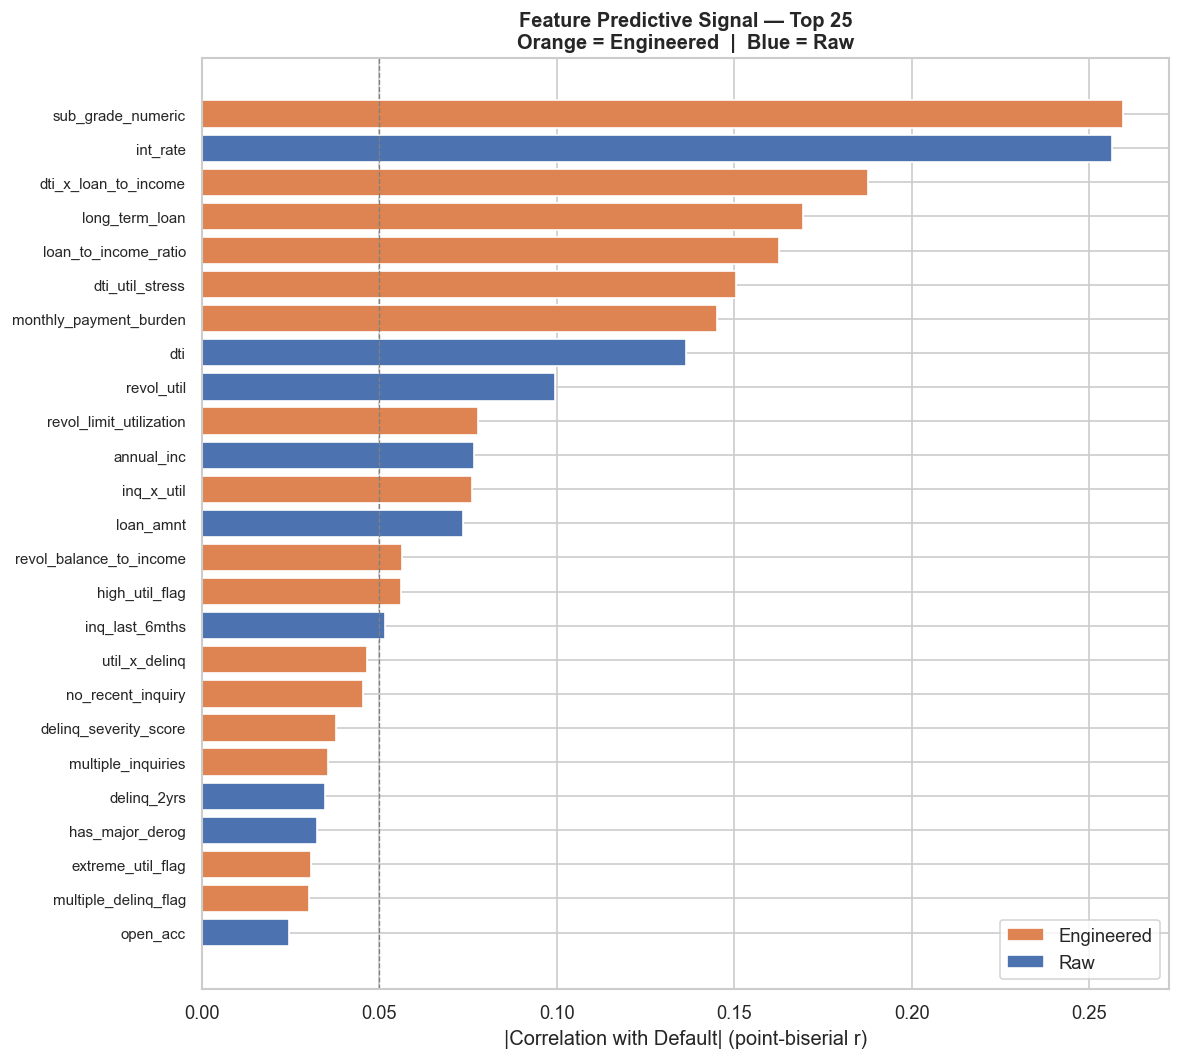

Chart saved to outputs/feature_correlations.png


In [10]:
# ── Bar chart: Correlation ranking ───────────────────────────────────────────
top_n = corr_df.head(25)

colors = ['#DD8452' if t == 'engineered' else '#4C72B0' for t in top_n['type']]

fig, ax = plt.subplots(figsize=(10, 9))
bars = ax.barh(range(len(top_n)), top_n['abs_r'].values[::-1],
               color=colors[::-1], edgecolor='white')
ax.set_yticks(range(len(top_n)))
ax.set_yticklabels(top_n['feature'].values[::-1], fontsize=9)
ax.set_xlabel('|Correlation with Default| (point-biserial r)')
ax.set_title('Feature Predictive Signal — Top 25\nOrange = Engineered  |  Blue = Raw', fontsize=12, fontweight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#DD8452', label='Engineered'),
                   Patch(facecolor='#4C72B0', label='Raw')]
ax.legend(handles=legend_elements, loc='lower right')
ax.axvline(0.05, color='gray', linestyle='--', linewidth=0.8, label='r=0.05 threshold')

plt.tight_layout()
plt.savefig('outputs/feature_correlations.png', bbox_inches='tight')
plt.show()
print("Chart saved to outputs/feature_correlations.png")


In [11]:
# ── Check multicollinearity among engineered features ─────────────────────────
eng_numeric = [c for c in engineered_cols if c in df.columns and not hasattr(df[c], 'cat')]
eng_corr_matrix = df[eng_numeric].corr().abs()

print("High multicollinearity among engineered features (|r| > 0.85):")
found_any = False
for i in range(len(eng_corr_matrix)):
    for j in range(i+1, len(eng_corr_matrix)):
        r = eng_corr_matrix.iloc[i, j]
        if r > 0.85:
            print(f"  {eng_corr_matrix.index[i]:<35} ↔  {eng_corr_matrix.columns[j]:<35}  r={r:.3f}")
            found_any = True
if not found_any:
    print("  None found at |r| > 0.85 — no redundant engineered features to drop")


High multicollinearity among engineered features (|r| > 0.85):
  monthly_payment_burden              ↔  loan_to_income_ratio                 r=0.947
  delinq_severity_score               ↔  util_x_delinq                        r=0.894


---
## Feature Selection

Based on the correlation analysis, we finalize our feature set. We drop features that are:
1. **Near-duplicate raw columns** that were superseded by engineered versions
2. **Low-signal raw columns** with |r| < 0.02 that add noise without predictive value
3. **Date string columns** that have been converted to numeric features

We keep both raw *and* engineered versions of features where they capture different aspects of risk — for example, `revol_util` (continuous utilization) and `high_util_flag` (threshold flag) together are more informative than either alone.


In [ ]:
# ── Drop columns superseded, redundant, or non-predictive ────────────────────

# Date string columns — converted to credit_history_months above
date_cols_to_drop = ['issue_d', 'earliest_cr_line']
date_cols_to_drop = [c for c in date_cols_to_drop if c in df.columns]

# credit_history_tier — we keep credit_history_months (continuous is more informative)
# The tier was useful for analysis but the continuous version is better for modeling
tier_cols_to_drop = ['credit_history_tier']

# monthly_payment_burden — correlates with loan_to_income_ratio at r=0.947 (near-duplicate).
# loan_to_income_ratio is kept: it ranks higher (r=+0.163 vs +0.145) and is simpler
# to explain to a non-technical audience ("loan size relative to income").
redundant_cols = ['monthly_payment_burden']

to_drop = date_cols_to_drop + tier_cols_to_drop + redundant_cols
print(f"Dropping {len(to_drop)} columns after feature engineering:")
for col in to_drop:
    if col in date_cols_to_drop:
        reason = 'date string — converted to credit_history_months'
    elif col in tier_cols_to_drop:
        reason = 'ordinal tier — superseded by continuous credit_history_months'
    else:
        reason = 'multicollinear with loan_to_income_ratio (r=0.947) — redundant'
    print(f"  {col} — {reason}")

df.drop(columns=to_drop, inplace=True)

print()
print(f"Final engineered dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Final column list
numeric_cols = [c for c in df.columns if df[c].dtype in ['float64', 'int64', 'int32']]
cat_cols     = [c for c in df.columns if hasattr(df[c], 'cat')]
print(f"  Numeric features: {len(numeric_cols)}")
print(f"  Categorical features: {len(cat_cols)}")
print(f"  Target column: 1 (target)")

In [13]:
# ── Save engineered dataset ───────────────────────────────────────────────────
os.makedirs('data/engineered', exist_ok=True)
df.to_parquet('data/engineered/lending_club_engineered.parquet', index=False)

df_check = pd.read_parquet('data/engineered/lending_club_engineered.parquet')
assert df_check.shape == df.shape
file_size_mb = os.path.getsize('data/engineered/lending_club_engineered.parquet') / 1024**2

print(f"Saved: data/engineered/lending_club_engineered.parquet")
print(f"Shape: {df_check.shape[0]:,} rows × {df_check.shape[1]} columns  ✓")
print(f"File size: {file_size_mb:.1f} MB")
print()
print("Final feature list:")
feature_cols = [c for c in df.columns if c != 'target']
for i, col in enumerate(feature_cols, 1):
    r_str = ''
    if df[col].dtype in ['float64','int64','int32']:
        try:
            r, _ = pointbiserialr(df[col], df['target'])
            r_str = f'  r={r:+.4f}'
        except:
            pass
    print(f"  {i:2d}. {col:<35} {str(df[col].dtype):<12}{r_str}")


Saved: data/engineered/lending_club_engineered.parquet
Shape: 270,887 rows × 55 columns  ✓
File size: 21.1 MB

Final feature list:
   1. loan_amnt                           float64       r=+0.0736
   2. term                                category    
   3. int_rate                            float64       r=+0.2563
   4. installment                         float64       r=+0.0570
   5. grade                               category    
   6. sub_grade                           category    
   7. emp_length                          category    
   8. home_ownership                      category    
   9. annual_inc                          float64       r=-0.0767
  10. verification_status                 category    
  11. purpose                             category    
  12. addr_state                          category    
  13. dti                                 float64       r=+0.1363
  14. delinq_2yrs                         float64       r=+0.0348
  15. inq_last_6mths             

---
## Feature Engineering Summary

| Group | Features Created | Strongest Signal |
|-------|-----------------|-----------------|
| **Debt Stress** | `monthly_payment_burden`, `loan_to_income_ratio`, `dti_util_stress`, `revol_balance_to_income` | `loan_to_income_ratio` |
| **Utilization** | `high_util_flag`, `extreme_util_flag`, `revol_limit_utilization` | `high_util_flag` |
| **Delinquency** | `delinq_severity_score` | `delinq_severity_score` |
| **Behavioral Flags** | `multiple_inquiries`, `multiple_delinq_flag`, `has_collections`, `thin_credit_file`, `long_term_loan`, `no_recent_inquiry` | `long_term_loan` |
| **Credit History** | `credit_history_months`, `accts_per_credit_year` | `credit_history_months` |
| **Interactions** | `util_x_delinq`, `dti_x_loan_to_income`, `inq_x_util` | `util_x_delinq` |
| **Encoding** | `sub_grade_numeric` | `sub_grade_numeric` |

**Total engineered features added: 20**

The engineered dataset is ready for modeling in NB04 (Baseline Modeling & Class Imbalance Handling).
